# Big Data and Finding the "needle in the haystack" galaxies
*A python excersie notebook written by Lewis McMillan, Summer 2020. This notebook has benifited from examples provided by Rita Tojeiro, and the help of Anne-Marie Weijmans, and Simon Reynolds.*

In this notebook you will use data from the Sloan Digital Sky Survey (SDSS), to explore how astronomers interact with "big data", and how they can use various different measurments of galaxies shapes in order to find spiral galaxies, the mergering of multiple galaxies, and other interesting galaxies.

## SDSS and SciServer

As mentioned above, in this notebook we will use data from SDSS, which is is the largest astronmical dataset in the world currently. For eachs nights observing it generates around 200Gb of data. The laptop this notebook was written on has 256Gb of storage space, meaning that I could fit 1 nights observing data on my laptop with some space left over for all the programs I need to analysie the data.

If you are reading this then we assume that you havel alredy followed the instructions to get an account on SciServer, and have uploaded this notebook. In addition to this we assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands. If not please complete Rita Tojeiro's notebook's which cover these topics: link here

### Imports
To get started we first install and then import all the libraries we will need in this notebook

In [1]:
#install python libraries that are needed
#!pip install dataclasses                           # needed as Python is a lower version than code needs
#!pip install astropy                               # general purpose astronomy library
#!pip install photutils                             # photomertry general purpose library
#!pip install scikit-image                          # image anaylsis general purpose library
#!pip install tqdm                                  # pretty progress bar

import pawlikMorphLSST as pmlsst                    # Library for analysing galaxies
print("Galaxy analysis code imported")

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs                 # query with CasJobs
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                                  # standard Python lib for math ops
import pandas as pd                                 # data manipulation package
import matplotlib.pyplot as plt                     # another graphing package
from pathlib import Path                            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval    # for plotting clear images
from tqdm import tqdm_notebook                      # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor  # for running the code on more than 1 cpu
from IPython.display import clear_output            # allow nice printing
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Galaxy analysis code imported
SciServer libraries imported
Supporting libraries imported
Settings applied


## Querying the SDSS database

The SDSS data is stored in a SQL database. Databases can be thought of as large tables of information. SQL is  one language that can be used to communicate with databases via "queries". For each query command, the database returns an answer. Usually, this is a subsample of the original database, though SQL can operate on the data very effectively too. In this tutorial we will submit queries to the SDSS database to gather the information that we need, and we will use Python to operate on, manipulate, and vizualise that data.

An extensive tutorial on how to query the SDSS database is provided here: http://skyserver.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx . In short, nearly every SQL command consists of three blocks:

The SELECT block: it defines the quantities that you want your query to return.
The FROM block: it defines which tables of the database you want SQL to look in.
The WHERE block: it defines any constraints on the data that you want to impose.
In this Lab you won't have to write SQL queries from scratch, only execute commands that are already written for you.

Using SQL and SciServer to return galaxy data
For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx The following query returns specific information on a sample of galaxies, as a Pandas dataframe.


In [2]:
# Find objects in the Sloan Digital Sky Survey's.
#
# Query the Sloan Digital Sky Serveys' NSA catalog of galactical objects.
# For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx?cmd=description+nsatlas+U#&&history=description+nsatlas+U
#
# This query finds all galaxies in the value added catalogue PawlikMorph and matches this information to the
# MaNGA catalogue in order to get galaxies positions.
# Finally we discard any galaxies that have incomplete measurments
#
# First, store the query in an object called "query"
query="""
select distinct m.objra, m.objdec, p.A, p.[As], p.As90, p.S, p.G, p.C2080, p.C5090, p.M20, p.run, p.rerun, p.camcol, p.field
from dbo.PawlikMorph p
  join dbo.mangaDAPall m
  on m.mangaID = p.mangaid
  """
#where p.warningflag = 0 and p.A > -99 and p.S > -99 and p.C2080 > -99 and p.C5090 > -99
#"""

#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print(f"SQL query returned {len(all_gals.index)} galaxies")

SQL query finished.
SQL query returned 4603 galaxies


The dataframe that is returned, named all_gals, holds the following quantities for each galaxy:
 * objra, objdec = The position of the galaxy. RA is the Right Ascension coordinate in degress, and DEC is the Declination corordiante in degrees
 * A = the asymmetry
 * As = the shape asymmetry at 180 degrees
 * As90 = the shape asymetry at 90 degrees
 * S = Smoothness parameter
 * G = Gini index
 * C2080, C5090 = The concentraion of light within a certain annulus
 * M20 = The 2nd moment of light
 * run, rerun, camccol, field = information about which part of the camera took the image
 
Lets look at what all this data looks like, but first lets add a new column to the dataframe which contains the path to the image on SciServer. This will be useful later in the notebook.
To do this we need the information about which part of the camera took the image.

In [3]:
# add a column to the dataframe, which contains the path to the image
def makename(df):
    root = "/home/idies/workspace/sdss_das/das2/imaging/"
    df["fname"] = df.apply(lambda row: root + f"{int(row.run)}/{int(row.rerun)}/corr/{int(row.camcol)}/fpC-{int(row.run):06}-r{int(row.camcol)}-{int(row.field):04}.fit.gz", axis=1)
    return df

# add filename column
all_gals = makename(all_gals)
# View the information of the first 10 galaxies retrieved
all_gals[0:10]

,objra,objdec,A,As,As90,S,G,C2080,C5090,M20,run,rerun,camcol,field,fname
0,27.475456,13.126633,-0.022468,0.149598,0.155957,0.049302,0.551373,3.09359,1.88380,-2.031580,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
1,27.529863,13.110374,0.043261,0.138830,0.173077,0.096871,0.653915,3.32362,2.13837,-2.078290,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
2,27.565306,13.140773,0.060645,0.171206,0.194553,0.115196,0.592129,2.94275,1.94163,-1.819910,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
3,27.653662,13.110200,0.165430,-99.000000,-99.000000,0.155478,0.826167,7.45512,5.86891,-0.568051,1035,40,2,145,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0145.fit.gz
4,27.842783,13.060335,0.204199,-99.000000,-99.000000,0.172169,0.849354,7.14371,5.69862,-0.552881,1035,40,2,146,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0146.fit.gz
5,27.886442,12.699600,0.010838,0.150585,0.690546,0.281075,0.456304,3.34295,2.06500,-1.765870,1035,40,1,147,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/1/fpC-001035-r1-0147.fit.gz
6,28.079226,13.634056,0.051562,0.170410,0.355398,0.070220,0.542558,3.69002,2.13114,-0.907639,1035,40,3,147,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/3/fpC-001035-r3-0147.fit.gz
7,28.185047,13.192551,0.030504,0.098608,0.207012,0.089205,0.650681,3.05745,1.91781,-2.076980,1035,40,2,148,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0148.fit.gz
8,28.375704,14.570949,0.043704,0.165480,0.434473,-99.000000,0.491647,3.35654,1.75424,-2.085590,1043,40,5,185,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/5/fpC-001043-r5-0185.fit.gz
9,28.443092,12.880449,0.079273,0.182746,0.226987,0.131965,0.628332,4.12512,2.52833,-1.914470,1043,40,1,186,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/1/fpC-001043-r1-0186.fit.gz


## Exercise:
 1. Plot the positions off all the galaxies using plt.scatter. Add appropriate labels and a title to your plot. As there is a large number of galaxies to plot you may want to use marker=".", and s="1".
 2. Can you explain why the distibution of galaxies is as shown? You may want to read https://blog.sdss.org/2015/06/11/how-sdss-used-light-to-make-the-largest-ever-image-of-the-night-sky/

Text(0.5, 1.0, 'Galaxy positions')

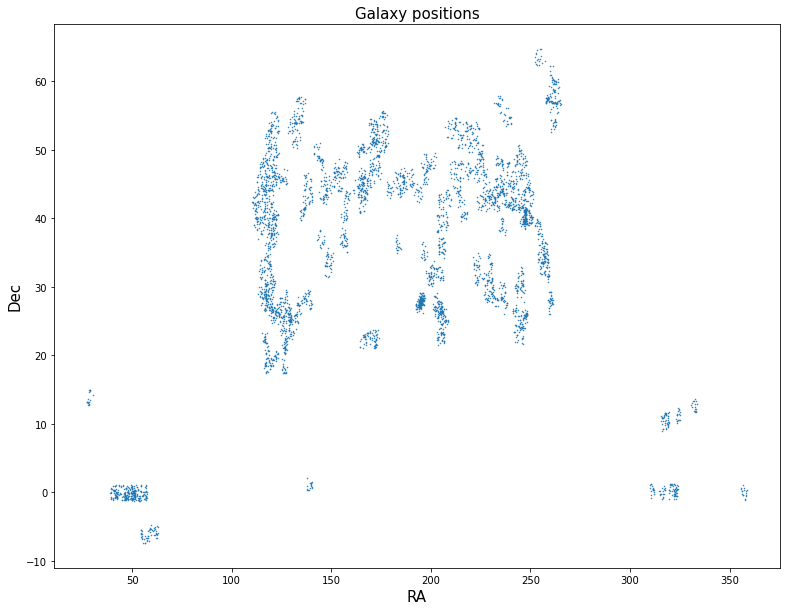

In [4]:
#possible solutions
#1.
plt.figure(figsize=(13,10))
plt.scatter(all_gals["objra"], all_gals["objdec"], s=1, marker=".")
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions', fontsize=15)
# 2. Would expect some anser along the lines that SDSS observes in stripes which gives the spider legs,
# and that galaxies are not uniformly distibuted not 

The following bit of code plots the first 16 galaxies from the data we downloaded.
## Exercise:
    1. Classify each image into its morphological type, i.e spiral, elliptical, ring or other

Read image 16 of 16
Plotting images...


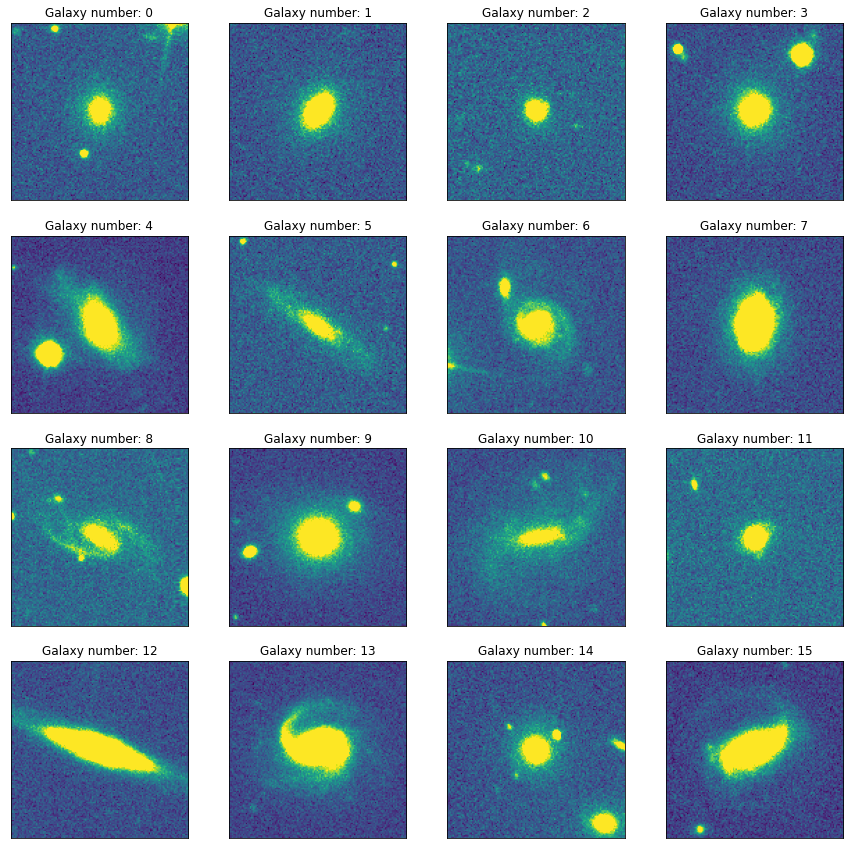

In [5]:
# display some galaxies in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

axs = axs.ravel()
i = 0
idx = 0
while True:
    clear_output(wait=True)
    print(f"Read image {i+1} of 16")
    filename = all_gals["fname"].iloc[idx]
    ra, dec = all_gals["objra"].iloc[idx], all_gals["objdec"].iloc[idx]
    # avoid any images that are on edge of image, so that we don't lose any light in calculations
    try:
       # read in image and crop to area of interest
        img = pmlsst.image.readImage("sdss", filename, ra, dec)
    except:
        idx += 1
        continue
    vmin, vmax = zscale.get_limits(img)
    axs[i].imshow(img, vmin=vmin, vmax=vmax, origin="lower")
    axs[i].set_title(f"Galaxy number: {idx}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

    if i == 15:
        break
    i += 1
    idx += 1
print("Plotting images...")

# Analysis of a single galaxy
Take your favoutite galaxy number from the plots above and use it in the following section.

In [6]:
fav_galaxy = all_gals.iloc[13]
filename = fav_galaxy["fname"]
ra, dec = fav_galaxy["objra"], fav_galaxy["objdec"]
# read in image and crop to area of interest
img = pmlsst.image.readImage("sdss", filename, ra, dec)

## Preprocessing the image
First we preprocess the image so that it is suitable for analysis.
This is done by first removing any source of light in the image that is not the "main" source.

In [7]:
# remove external light sources
img = pmlsst.imageutils.maskstarsSEG(img)

Next we estimate the value of the sky. This means we count all the values of the pixels that are not part of the galaxy. We then tak an average of these values to get out estimate for the value of the sky.

In [8]:
# estimate skybackground
skybgr, skybgr_err, *_ = pmlsst.skyBackground.skybgr(img)

The penuktimate step is to calculate the galaxy mask. A galaxy mask is an image where all the pixels have the values 1 or 0. Where the mask is 1, then that part of the image belongs to the galaxy, where it is 0 then that pixel belongs to the sky.
Defining a galaxy mask allows us to easily compute more complex parameters related to the galaxy when anaysing the images of the galaxy.

In [9]:
# create image where the only bright pixels are the pixels that belong to the galaxy
mask = pmlsst.pixmap.pixelmap(img, skybgr + skybgr_err, 3)

### Excercise:
    1. Plot both the image of your favourite galaxy from above alongside its mask
    2. Comment on the overall shape of the mask. How does your what your eye can see compare to what the 
       computer algorithm "see"?. You might want to play with the vmin and vmax values of the plot.

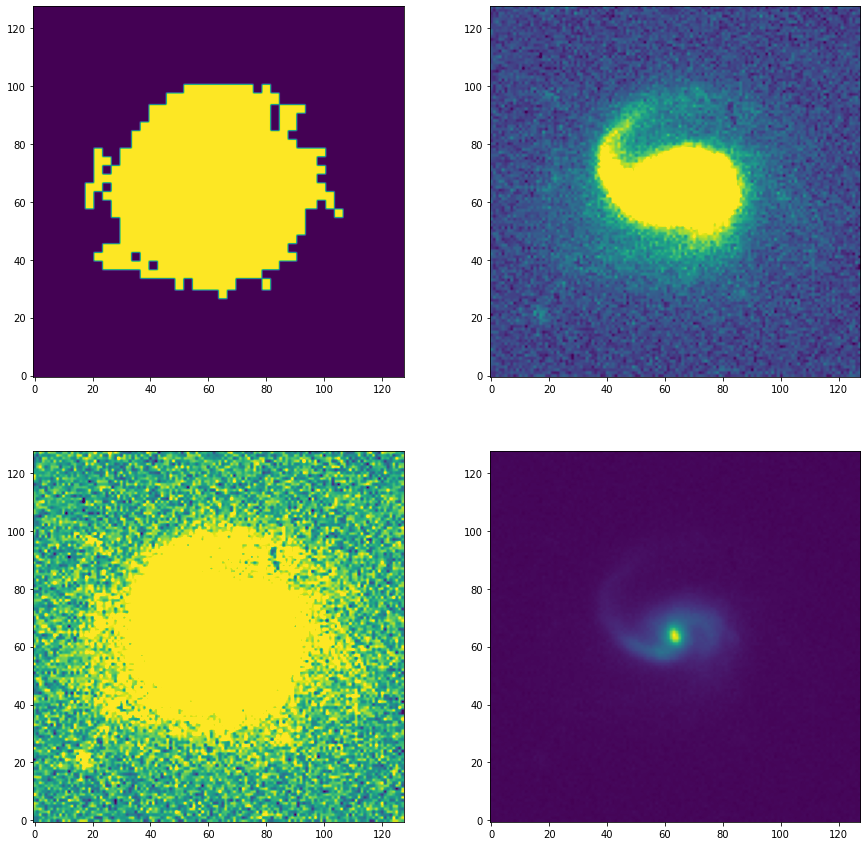

In [10]:
# possible solution
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()
axs[0].imshow(mask, origin="lower")
vmin, vmax = zscale.get_limits(img)
axs[1].imshow(img, vmin=vmin, vmax=vmax, origin="lower")
axs[2].imshow(img, vmin=vmin, vmax=vmin+30, origin="lower")
axs[3].imshow(img, origin="lower")

# Image analysis
In order to illustrate how the image analysis method works for galaxies, we will apply the technique to Emoji's.
First we need to load some libraries to process the emojis so that they are in a suitable format for the code 

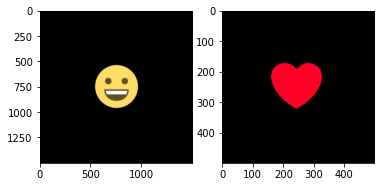

In [55]:
from skimage import io, color, transform
# read in the two images and plot them
img1 = io.imread("emoji-1.png")
img2 = io.imread("emoji-2.png")
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img1)
axs[1].imshow(img2)

We define a function that carries out all the processing steps for us

In [60]:
# set a seed so that the results are repoducible
np.random.seed(1)
def preprocessEmoji(img):
    # convert image to grayscale
    emoji = color.rgb2gray(img)
    # shrink image so that code can process image in a timely manner
    emoji = transform.resize(emoji, (500, 500))
    # add some noise to image so that code can process the images as expected
    emoji += (1./50.) * np.random.standard_normal(size=(500, 500))
    return emoji

Lets see how these preprocessing steps has affect the images

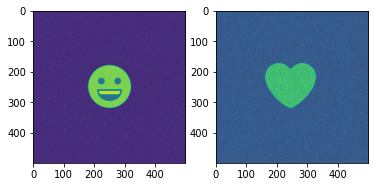

In [66]:
fig, axs = plt.subplots(1, 2)
img1 = preprocessEmoji(img1)
img2 = preprocessEmoji(img2)
axs[0].imshow(img1)
axs[1].imshow(img2)

As before lets calculate the "sky" value and generate the image masks

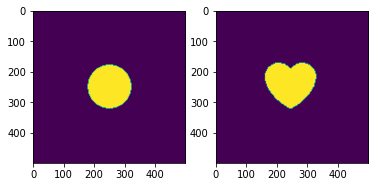

In [67]:
# get "sky" estimates and generate masks
skybgr, skybgr_err, *_ = pmlsst.skyBackground.skybgr(img1)
mask1 = pmlsst.pixmap.pixelmap(img1, skybgr + skybgr_err, 3)
skybgr, skybgr_err, *_ = pmlsst.skyBackground.skybgr(img2)
mask2 = pmlsst.pixmap.pixelmap(img2, skybgr + skybgr_err, 3)
# plot masks
fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask1)
axs[1].imshow(mask2)

Finally lets run the analysis code on the Emoji's. While the next step runs please continue to the next pieace of text as this can take around a minute to print a result.

In [70]:
# Calculate asymmetries
A, As, As90 = pmlsst.asymmetry.calculateAsymmetries(img1, mask1)
print(f"Smiley: A: {A:0.3f}, As: {As:.3f}, As90: {As90:.3f}")
A, As, As90 = pmlsst.asymmetry.calculateAsymmetries(img2, mask2)
print(f"Heart: A: {A:0.3f}, As: {As:.3f}, As90: {As90:.3f}")

Smiley: A: 0.091, As: 0.017, As90: 0.010
Heart: A: 0.109, As: 0.167, As90: 0.148


## Symmetry

calculateAsymmetries, as the name implies, calculates several asymmetry parameters of the input image using the image and its mask. 

So why is calculating a galaxies (or Emoji's) asymmetry important? The asymmetry parameters give vital information about the shape of the galaxy, allowing astronomers to search for interesting galaxies. 

Of particular interest are galaxies where they have undergone a merger with another galaxy, or have been disturbed by another galaxy. Investigating these "messed up" galaxies allow astronomers to get insights into the life cycle of galaxies. 

These messed up galaxies are fairly easy to identify by eye, however to to the sheer number of galaxies detected in the SDSS database it is not possible for a person to go through all the galaxies by hand and pick out the interesting galaxies. We therefore rely on computer algorithms to do this for us.

So how does a computer define asymmetry? We will explore this by first examining how a human does this.

## Exercise:
    1. How many lines of symmetry do the two Emoji images have?
    2. If the smiley was just a circle (i.e had no face) would it have any more symmetries?
    3. How symmetric is your favourite galaxy from before. Does it have any lines of symmerty?
    4. What process did you use to determine the lines of symmetry in the Emoji example?

In [84]:
#possible solutions:
#1. the smiley has 1, as does the heart
#2. it now has rotational symmetry and infinte many lines of symmetry
#3. Depends on the galaxy choosen.
#4. Student should explain the process of finding lines of symmetry, i.e folding over the images along different creases

Now that you have a feel for how a human might classify symmetry we can move on to programming the computer to find symmetries as well.
Finding lines of symmetry computationally is not straight forward for complex shape. 
We therefore use rotational symmetry to calculate the asymmetry of complesx galaxies.
To achieve this we rotate the image by 180 degrees, and then take it away from the original image.
Below is a function that helps to do this.

In [71]:
def rotationalDifference(img, angle):
    point = (250, 250)
    rotate = transform.rotate(img, angle, center=point, preserve_range=True)
    res = np.abs(img - rotate)
    return res

## Exercise
    1. Calculate the asymmetry using the above function and plot the result for the heart and simley face
    2. Do the same but this 

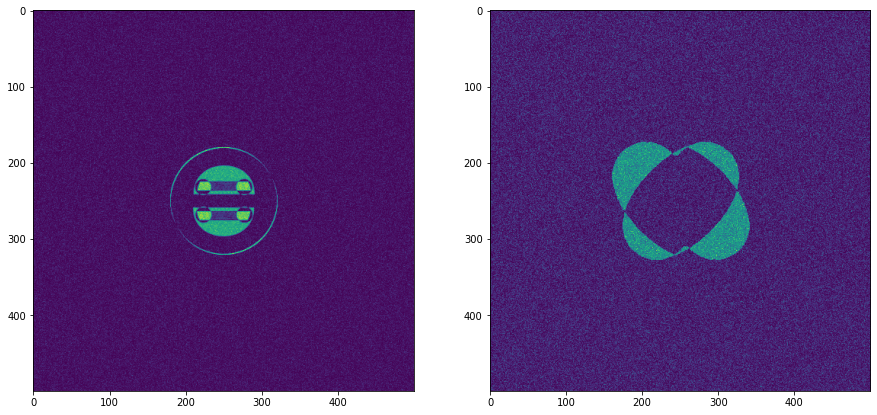

In [72]:
# possible solution
res1 = rotationalDifference(img1, 180.)
res2 = rotationalDifference(img2, 180.)

fig, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].imshow(res1)
axs[1].imshow(res2)

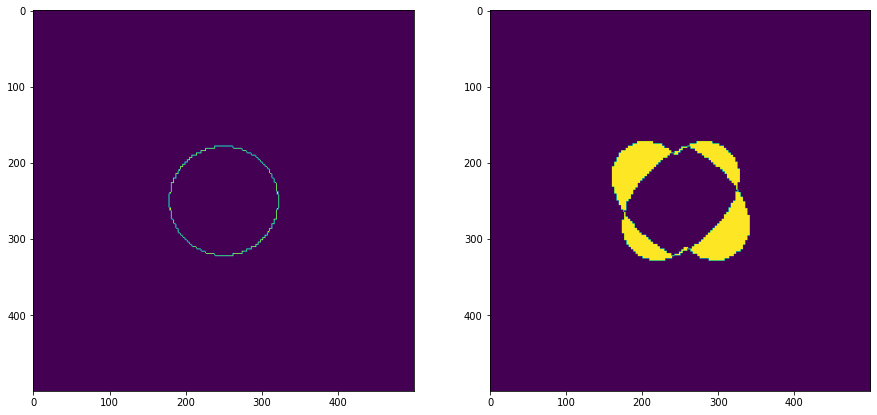

In [69]:
res1 = rotatioalDifference(mask1, 180.)
res2 = rotatioalDifference(mask2, 180.)

fig, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].imshow(res1)
axs[1].imshow(res2)

## Processing big data
TODO
ideas:
    1. get students to time single core vs many -> use a learning oppituinty to introduce Amdahls law etc?
    2. get students to find messed up galaxies -> maybe next notebook?

In [ ]:
# Using "single" CPU
results = []
for info in tqdm_notebook(filenames[:100]):
    results.append(analyseImage(info))

In [ ]:
results = []
with ProcessPoolExecutor(max_workers=4) as pool:
    for result in tqdm_notebook(pool.map(pmlsst.helpers.analyseImage, filenames[:100]), total=len(filenames)):
         results.append(result)

In [ ]:
# process results
finalResults = {"A": [], "As": [], "As90": [], "C": [], "S": [], "g": [], "m20": [], "fname": [], "radec": []}
for result in results:
    if result[0] != -99:
        finalResults["A"].append(result[0])
        finalResults["As"].append(result[1])
        finalResults["As90"].append(result[2])
        finalResults["C"].append(result[3])
        finalResults["S"].append(result[4])
        finalResults["g"].append(result[5])
        finalResults["m20"].append(result[6])
        finalResults["fname"].append(result[7])
        finalResults["radec"].append((result[8], result[9]))
df = pandas.DataFrame.from_dict(finalResults)
hist = df.hist(bins=20,figsize=(15,15))

In [ ]:
from astropy import wcs
mergers = df.query("C >= 4.")
print(len(mergers.index))
imgs = mergers.iloc[:16]

fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
for i in range(len(imgs.index)):
    filename = imgs["fname"].iloc[i]
    ra, dec = imgs["radec"].iloc[i]
    image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    image = pmlsst.imageutils.maskstarsSEG(image)

    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")

In [ ]:
import SciServer.SkyServer as SkyServer
mergers = all_gals.query("As >= 0.2")
fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
pixelsize=.369
for i in range(16):
    filename = mergers["fname"].iloc[i]
    ra, dec = mergers["objra"].iloc[i], mergers["objdec"].iloc[i]
    #image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    #image = pmlsst.imageutils.maskstarsSEG(image)
#     scale = 2.*mergers["rmax"]/pixelsize/200
#     print(scale)
    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=200, height=200, scale=.3, dataRelease='DR16')
    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")